## Libraries and Prerequisite

In [35]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook
from tqdm import tqdm
from numpy.random import seed
import tensorflow as tf
tf.random.set_seed(42)
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [36]:
# ---- put these near the top, after imports ----
import os, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.backend import clear_session

def set_all_seeds(seed: int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)                 # Python RNG
    np.random.seed(seed)              # NumPy RNG
    tf.random.set_seed(seed)          # TensorFlow RNG
    try:
        # Keras 3 / TF 2.18+ helper (sets TF + Python + NumPy)
        tf.keras.utils.set_random_seed(seed)
    except Exception:
        pass
    # (optional but recommended) force deterministic ops where possible
    try:
        tf.config.experimental.enable_op_determinism(True)
    except Exception:
        pass


## Parameters

In [37]:
#Data Parameters
num_of_classes = 4
data_shape = (7,1)

#MLP Parameters
times_to_run = 50 #Number of times to run MLP model
mlp_epochs = 40
valid_split = 0.20

#GAN Parameters
latent_dim = 100
gan_epochs = 5000

#Random Seeds
selection_seed = 150
seed_multiplier = 1000000

In [38]:
cb1 = widgets.Checkbox(description="Generate missing data only")
slider1 = widgets.FloatSlider(value=0.1, min=0.05, max=1, step=0.05)
slider2 = widgets.IntSlider(value=250, min=0, max=1000, step=250)
vb = widgets.VBox(children = [slider2])
def checkbox(button):
    if button['new']:
        vb.children = []
        slider2.value = 250 - int(slider1.value*250) 
    else:
        vb.children = [slider2]
        experiment3 = False
cb1.observe(checkbox, names='value')

print("Percentage of Real Data:")
display(slider1)
print("Number of datapoints GAN generates:")
display(vb)
display(cb1)


Percentage of Real Data:


FloatSlider(value=0.1, max=1.0, min=0.05, step=0.05)

Number of datapoints GAN generates:


Checkbox(value=False, description='Generate missing data only')

In [39]:
fraction_of_data = slider1.value
data_to_gen = slider2.value

## Data preprocessing


In [40]:
dataset = pd.read_csv("./data/dataset.csv")
labels = dataset.Class.values
labels = labels - 1 #Original label values are from 1 to 4
features = dataset.drop(columns='Class').values

In [41]:
tr_fea, X_test, tr_label, Y_test = train_test_split(features, 
                                                    labels, 
                                                    test_size=0.5,
                                                    random_state= selection_seed,
                                                    stratify=labels)


In [42]:
X_train = []
Z_train = [] #This is the same as X_train, but it's used for training the GAN
Y_train = []

for idx in range(4):
    number_filter = np.where(tr_label == idx)
    X_filtered, Y_filtered = tr_fea[number_filter], tr_label[number_filter]

    num_of_data = (int)(fraction_of_data*X_filtered.shape[0])
    RandIndex = np.random.choice(X_filtered.shape[0], 
                                 num_of_data, 
                                 replace=False)
    Z_train.append(X_filtered[RandIndex])
    X_train.extend(X_filtered[RandIndex])
    Y_train.extend(Y_filtered[RandIndex])

X_train = np.asarray(X_train, dtype=np.float32)
Y_train = np.asarray(Y_train, dtype=np.float32)

X_train, Y_train = shuffle(X_train, Y_train)

Y_train_encoded = to_categorical(Y_train)
Y_test_encoded = to_categorical(Y_test)

In [43]:
#Data must be standized using standard scaler before using the MLP.
scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.fit_transform(X_test)

# Classification with MLP for Real Data

In [44]:
from keras.src.utils import set_random_seed

# replace these:
# from tqdm import tqdm_notebook
# from tqdm import tqdm

# with this robust import:
try:
    from tqdm.notebook import tqdm  # Jupyter/Lab progress bars
except ImportError:
    from tqdm import tqdm           # fallback (terminal)

all_test_loss =[]
all_test_acc = []
history = []

for i in tqdm_notebook(range(times_to_run)):
    seed(i*seed_multiplier)
    set_random_seed(i*seed_multiplier)

    model = Sequential()
    model.add(Dense(128, input_shape=(7,), activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=Adam(0.0002, 0.5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    history_temp = model.fit(X_train_transformed,
                            Y_train_encoded,
                            epochs=mlp_epochs,
                            batch_size=64,
                            validation_split=valid_split,
                            verbose=0)
    history.append(history_temp)
    test_loss, test_acc = model.evaluate(X_test_transformed, 
                                         Y_test_encoded, 
                                         verbose=0)

    all_test_acc.append(test_acc)
    all_test_loss.append(test_loss)
    del(model)
    clear_session()

/var/folders/m2/75hy0y_x7_32w4qbfntqhrn40000gn/T/ipykernel_1487/545212415.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(times_to_run)):


  0%|          | 0/50 [00:00<?, ?it/s]

/Users/gaziza/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


FileNotFoundError: [Errno 2] No such file or directory: './results/original/Train - 10.0%.png'

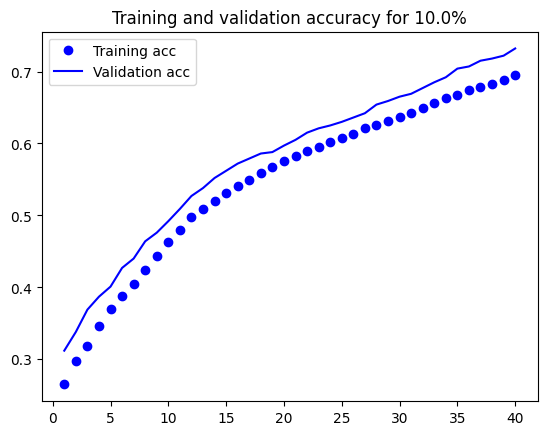

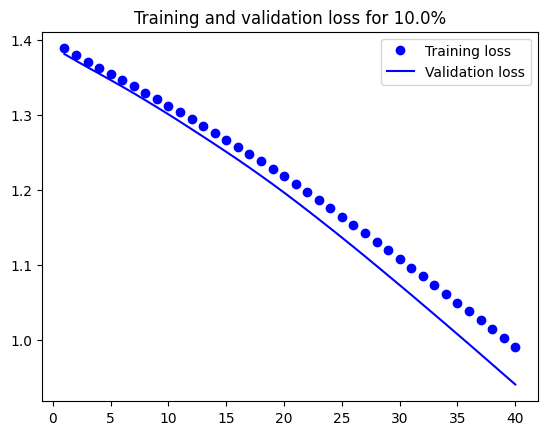

In [46]:
trainacc = []
trainloss = []
valacc = []
valloss = []
for i in range (len(history)):
    trainacc.append(history[i].history['accuracy'])
    trainloss.append(history[i].history['loss'])
    valacc.append(history[i].history['val_accuracy'])
    valloss.append(history[i].history['val_loss'])

acc = np.mean(trainacc, axis=0)
val_acc = np.mean(valacc, axis=0)
loss = np.mean(trainloss, axis=0)
val_loss = np.mean(valloss, axis=0)
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy for {}%'.format(fraction_of_data*100))
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for {}%'.format(fraction_of_data*100))
plt.legend()
plt.savefig("./results/original/Train - {}%.png".format(fraction_of_data*100))

# Generating Synthetic Data


In [17]:
def build_generator():
    model = Sequential()
    
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(data_shape), activation='tanh'))
    model.add(Reshape(data_shape))

    #model.summary()

    noise = Input(shape=(latent_dim,))
    gendata = model(noise)
    
    return Model(noise, gendata)

In [18]:
def build_discriminator():

    model = Sequential()

    model.add(Flatten(input_shape=data_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    #model.summary()

    data = Input(shape=data_shape)
    validity = model(data)

    return Model(data, validity)

In [19]:
def train(epochs, features, batch_size=128):

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
            idx = np.random.randint(0, features.shape[0], batch_size)
            data = features[idx]

            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            gen_data = generator.predict(noise)

            d_loss_real = discriminator.train_on_batch(data, valid)
            d_loss_fake = discriminator.train_on_batch(gen_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            g_loss = combined.train_on_batch(noise, valid)

**Training GAN**

In [ ]:
gen_data = []

for i in tqdm(range(num_of_classes)):
    discriminator = build_discriminator()
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=Adam(0.0002, 0.5),
                          metrics=['accuracy'])
    
    generator = build_generator()
    noise = Input(shape=(latent_dim,))
    gendata = generator(noise)
    discriminator.trainable = False
    validity = discriminator(gendata)
    combined = Model(noise, validity)
    combined.compile(loss='binary_crossentropy',
                    optimizer=Adam(0.0002, 0.5))

    minimaxscaler = MinMaxScaler((-1,1))
    Z_train_transformed = minimaxscaler.fit_transform(Z_train[i])
    Z_train_transformed = np.expand_dims(Z_train_transformed, axis=2)

    train(epochs=gan_epochs,
          features=Z_train_transformed,
          batch_size=64)
        
    noise = np.random.normal(0, 1, (data_to_gen, latent_dim))
    gen_data_temp = generator.predict(noise)
    gen_data_temp = np.asarray(gen_data_temp, dtype=np.float32)
    gen_data_temp = np.squeeze(gen_data_temp)
    gen_data_temp = minimaxscaler.inverse_transform(gen_data_temp)

    gen_data.append(gen_data_temp)

    clear_session()
    del(discriminator)
    del(generator)
    del(combined)

gen_data = np.asarray(gen_data, dtype=np.float32)

# Classification with MLP for Real + Synthetic Data

**Preprocess synthetic data**

In [21]:
gen_label = []
for i in range(4):
    gen_label_temp = np.tile(i, data_to_gen)
    gen_label.extend(gen_label_temp)

gen_label = np.asarray(gen_label, dtype=np.float32)
gen_label_encoded = to_categorical(gen_label)

In [22]:
gen_data_reshaped = gen_data.reshape(num_of_classes*data_to_gen, data_shape[0])

X_train_gan, Y_train_gan = shuffle(gen_data_reshaped,
                                   gen_label_encoded, 
                                   random_state=5)


In [23]:
new_x_train = np.concatenate((X_train, X_train_gan), axis=0)
new_y_train = np.concatenate((Y_train_encoded, Y_train_gan), axis=0)

new_x_train, new_y_train = shuffle(new_x_train, new_y_train, random_state=15)
new_x_train_transformed = scaler.fit_transform(new_x_train)

**Train a new MLP on Real+Synthetic Data**

In [ ]:
all_test_loss_gan =[]
all_test_acc_gan = []
ganhistory = []

for i in tqdm_notebook(range(50)):
    seed(i*seed_multiplier)
    set_random_seed(i*seed_multiplier)

    model = Sequential()
    model.add(Dense(128, input_shape=(7,), activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=Adam(0.0002, 0.5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    ganhistorytemp = model.fit(new_x_train_transformed,
                    new_y_train,
                    epochs=mlp_epochs,
                    batch_size=64,
                    validation_split=valid_split,
                    verbose = 0)
    ganhistory.append(ganhistorytemp)

    test_loss, test_acc = model.evaluate(X_test_transformed, 
                                         Y_test_encoded, 
                                         verbose=0)
    print("#{} Test acc:".format(i), test_acc)

    all_test_acc_gan.append(test_acc)
    all_test_loss_gan.append(test_loss)
    del(model)
    clear_session()

In [ ]:
gantrainacc = []
gantrainloss = []
ganvalacc = []
ganvalloss = []
for i in range (len(ganhistory)):
    gantrainacc.append(ganhistory[i].history['acc'])
    gantrainloss.append(ganhistory[i].history['loss'])
    ganvalacc.append(ganhistory[i].history['val_acc'])
    ganvalloss.append(ganhistory[i].history['val_loss'])

gan_acc = np.mean(gantrainacc, axis=0)
gan_val_acc = np.mean(ganvalacc, axis=0)
gan_loss = np.mean(gantrainloss, axis=0)
gan_val_loss = np.mean(ganvalloss, axis=0)
epochs = range(1, len(gan_acc) + 1)
plt.plot(epochs, gan_acc, 'bo', label='Training acc')
plt.plot(epochs, gan_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy for {}%'.format(fraction_of_data*100))
plt.legend()
plt.figure()
plt.plot(epochs, gan_loss, 'bo', label='Training loss')
plt.plot(epochs, gan_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for {}%'.format(fraction_of_data*100))
plt.legend()
plt.savefig("./Results/GAN/Train - {}%.png".format(fraction_of_data*100))

# Save Results

In [28]:
AccMean = np.mean(all_test_acc)
LossMean = np.mean(all_test_loss)
AccStd = np.std(all_test_acc)
LossStd = np.std(all_test_loss)

GanAccMean = np.mean(all_test_acc_gan)
GanLossMean = np.mean(all_test_loss_gan)
GanAccStd = np.std(all_test_acc_gan)
GanLossStd = np.std(all_test_loss_gan)

lines  = list()
lines.append("Original Data (Each Class: {} Real):".format(num_of_data))
lines.append("Accuracy mean: {}".format(AccMean))
lines.append("Loss mean: {}".format(LossMean))
lines.append("Accuracy STD: {}".format(AccStd))
lines.append("Loss STD: {} \n".format(LossStd))
lines.append("Maximum Accuracy: {}".format(np.max(all_test_acc)))
lines.append("Loss of Maximum Accuracy: {}".format(
    all_test_loss[np.argmax(all_test_acc)]))

lines.append("\n ================== \n")
lines.append("Original + GAN Data" +
             "(Each Class: {} Real + {} GAN):".format(num_of_data, 
                                                      data_to_gen))
lines.append("Accuracy mean: {}".format(GanAccMean))
lines.append("Loss mean: {}".format(GanLossMean))
lines.append("Accuracy STD: {}".format(GanAccStd))
lines.append("Loss STD: {} \n".format(GanLossStd))
lines.append("Maximum Accuracy: {}".format(np.max(all_test_acc_gan)))
lines.append("Loss of Maximum Accuracy: {}".format(
    all_test_loss_gan[np.argmax(all_test_acc_gan)]))


file_dir = "./results/Test - {}%.txt".format(fraction_of_data*100)
with open(file_dir, "w") as filehandle:
    for items in lines:
        filehandle.write('%s\n' % items)